In [15]:
from salad.serialize import read
from salad.analysis.plot import plot_summary_coadds, plot_summary_light_curve
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from pathlib import Path

def load_summary(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_summary.pkl"))[0])


In [310]:
def coadds_plot(cluster, exclude_masks=["FAKE", "INJECTED"]):
    s = cluster.summary
    points = cluster.points
    
    included = []
    excluded = []
    e2 = points[:, -1].astype(int)
    for i, e in enumerate(s['expnum']):
        if e in e2:
            included.append(i)
        else:
            excluded.append(i)

    included = np.array(included)
    excluded = np.array(excluded)
    total = np.array([i for i in range(len(s['expnum']))])
    
    # coadds plot:
    fig = plt.figure(dpi=150)
    axs = fig.subplots(3, 5, sharex=True, sharey=True)
    for i, idx in enumerate([total, included, excluded]):
        for j, value in enumerate(['mean', 'sum', 'median', 'weighted', 'mask']):
            if len(idx) == 0:
                continue
            image = s['image'][idx]
            variance = s['variance'][idx]
            mask = s['mask'][idx]
            
            plt.sca(axs[i, j])
            cmap = 'gray_r'
            if value == 'weighted':
                v = (np.sum((image / variance), axis=0) / np.sum(1/variance, axis=0))
            elif value == 'mask':
                v = np.bitwise_or.reduce(mask, axis=0)
                for m in exclude_masks:
                    b = s['mask_plane_dict'][0][m]
                    v[np.where(((v >> b) & 1) == 1)] -= 2**b
                cmap = None
            else:
                v = getattr(np, value)(image, axis=0)
                
                
            plt.imshow(v, cmap=cmap)
            plt.title(value)
            if j == 0:
                label = {
                    0: f"all (N={len(total)})",
                    1: f"detected (N={len(included)})",
                    2: f"undetected (N={len(excluded)})"
                }
                plt.ylabel(label.get(i))
            plt.xticks([])
            plt.yticks([])
    return fig

In [263]:
clusters[2].summary['mask_plane_dict'][0]

{'BAD': 0,
 'CLIPPED': 9,
 'CR': 3,
 'CROSSTALK': 10,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'FAKE': 11,
 'INEXACT_PSF': 12,
 'INJECTED': 13,
 'INJECTED_TEMPLATE': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 15,
 'NO_DATA': 8,
 'REJECTED': 16,
 'SAT': 1,
 'SENSOR_EDGE': 17,
 'STREAK': 18,
 'SUSPECT': 7,
 'UNMASKEDNAN': 19}

In [ ]:
plot_masks = ['BAD', 'CLIPPED', 'CR', 'CROSSTALK', 'EDGE', 'INEXACT_PSF', 'INTRP', 'NO_DATA', 'SAT', 'SUSPECT']

In [311]:
import matplotlib
from matplotlib.lines import Line2D

def lightcurve_plot(cluster, exclude_masks=["FAKE", "INJECTED"]):
    # flux / mag / snr
    # colors: included / mask
    s = cluster.summary
    points = cluster.points
    
    included = []
    excluded = []
    e2 = points[:, -1].astype(int)
    for i, e in enumerate(s['expnum']):
        included.append(e in e2)
        excluded.append(e not in e2)

    included = np.array(included)
    excluded = np.array(excluded)
    total = np.array([i for i in range(len(s['expnum']))])
    
    v = s['light_curve']['mask']
    for m in exclude_masks:
        b = s['mask_plane_dict'][0][m]
        v[np.where(((v >> b) & 1) == 1)] -= 2**b    

    included_mask = v == 0
    excluded_mask = v != 0
    
    # coadds plot:
    fig = plt.figure(dpi=150, figsize=(9, 5))
    axs = fig.subplots(3, 2, sharex=True, sharey=False)
    axs = np.atleast_2d(axs)
    x = np.arange(len(s['expnum']))
    
    for j, (incl, excl) in enumerate(zip([included, included_mask], [excluded, excluded_mask])):
        plt.sca(axs[0, j])
        plt.errorbar(
            x[incl], 
            s['light_curve']['flux'][incl], 
            yerr=s['light_curve']['sigma'][incl],
            fmt='o',
            ms=2,
        )
        if excl.sum() > 0:
            plt.errorbar(
                x[excl], 
                s['light_curve']['flux'][excl], 
                yerr=s['light_curve']['sigma'][excl],
                fmt='o',
                ms=2,
            )

        plt.sca(axs[1, j])
        plt.scatter(
            x[incl], 
            s['light_curve']['mag'][incl], 
            s=2,
        )
        if len(excl) > 0:
            plt.scatter(
                x[excl], 
                s['light_curve']['mag'][excl], 
                s=2,
            )

        plt.gca().invert_yaxis()

        plt.sca(axs[2, j])
        plt.scatter(
            x[incl], 
            s['light_curve']['snr'][incl], 
            s=2,
        )
        if len(excl) > 0:
            plt.scatter(
                x[excl], 
                s['light_curve']['snr'][excl], 
                s=2,
            )
        
    
        
    plt.sca(axs[0, 0])
    plt.ylabel("Flux")
    plt.sca(axs[1, 0])
    plt.ylabel("Mag")
    plt.sca(axs[2, 0])
    plt.ylabel("SNR")
    plt.xlabel("Obs #")
    custom_lines = [
        Line2D([0], [0], marker="o", lw=0, color='C0', markersize=2, markerfacecolor="C0", label=f"Detection"),
        Line2D([0], [0], marker="o", lw=0, color='C1', markersize=2, markerfacecolor="C1", label=f"Non-detection"),        
    ]
    fig.legend(handles=custom_lines, loc='upper left')
    
    plt.sca(axs[2, 1])
    plt.xlabel("observation number")
    custom_lines = [
        Line2D([0], [0], marker="o", lw=0, color='C0', markersize=2, markerfacecolor="C0", label=f"Unmasked"),
        Line2D([0], [0], marker="o", lw=0, color='C1', markersize=2, markerfacecolor="C1", label=f"Masked"),        
    ]
    fig.legend(handles=custom_lines, loc='upper right')
    
    return fig

In [319]:
c[58].summary

{'expnum': array([845872, 845873, 845874, 845875, 845876, 845877, 845878, 845879,
        845880, 845881, 845882, 845883, 845884, 845885, 845886, 845887,
        845888, 845889, 845890, 845891, 845892, 845893, 845894, 845895,
        845896, 845897, 845898, 845899, 845900, 845901, 845902, 845903,
        845904, 845905, 845906, 845907, 845908, 845909, 845910, 845911,
        845912, 845913, 845914, 845915, 845916, 845917, 845918, 845919,
        845920, 845921, 845922, 845923, 845924, 845925, 845926, 845927,
        845928, 845929, 845930, 845931, 845932, 845933, 845934, 845935,
        845936, 845937, 845938, 845939, 845940, 845941, 845942, 845943,
        845944, 845945, 845946, 845947, 845948, 845949, 845950, 845951,
        845952, 845953, 845954, 845955, 845956, 845957, 845958, 845959,
        845960, 845961, 845962, 845963, 845964, 845965, 845966, 845967,
        845968, 845969, 845970, 845971, 845972, 845973, 845974, 845975]),
 'image': array([[[ -8.319914  ,   7.749572  , -17.2

4 4


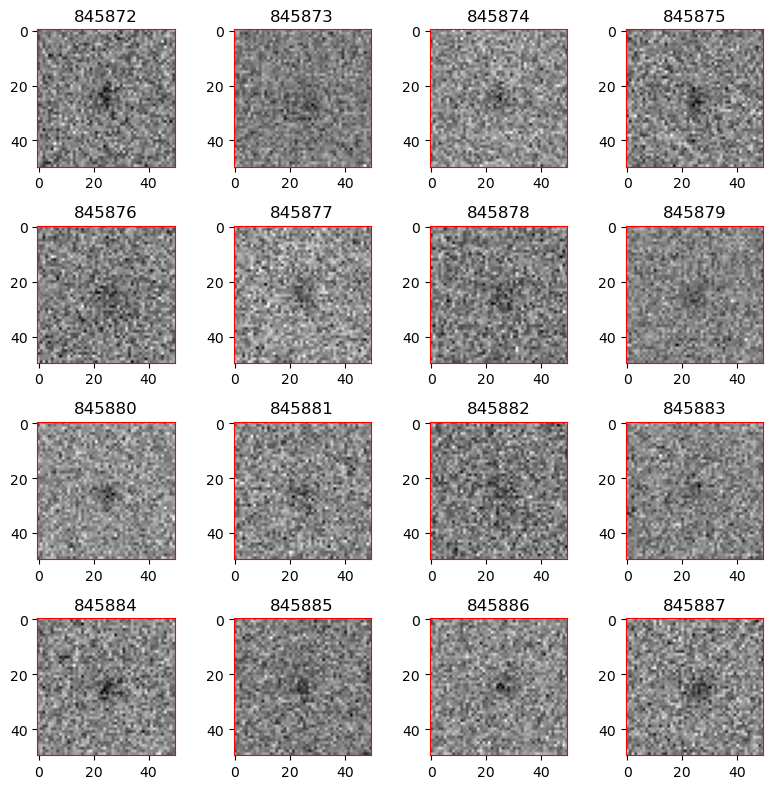

In [332]:
def summary_cutouts(
    cluster, 
    cols=None, rows=None, 
    component="image", 
    title="{e}",#"\n({x}, {y})\nSNR={significance:0.1f}", 
    show_colorbar=False, 
    highlight_points=True,
    limit=None,
    only_points=False,
    stretch="linear",
    scale="zscale",
    share_colorbar=False,
    **kwargs
):
    import matplotlib.pyplot as plt
    import numpy as np
    
    s = cluster.summary
    expnum = s['expnum']
        
    if only_points:
        expnum = sorted(list(set(cluster.points[:, 3])))
    
    if limit:
        expnum = expnum[:limit]
    
    if len(expnum) == 0:
        return None, None
    
    if rows is not None and cols is None:
        cols = len(expnum) / rows
    elif rows is None and cols is not None:
        rows = len(expnum) / cols
    elif rows is None and cols is None:
        cols = round((len(expnum))**0.5 + 0.5)
        rows = len(expnum)/cols
                
    if cols > len(expnum):
        cols = len(expnum)
        rows = 1

    if (cols - int(cols)) != 0:
        cols += 1
    cols = int(cols)
        
    if (rows - int(rows)) != 0:
        rows += 1
    rows = int(rows)

    print(rows, cols)
    fig = plt.figure(figsize=(cols*2, rows*2), **kwargs)
    axs = fig.subplots(rows, cols)
    axs = np.atleast_2d(axs)
#     display = afwDisplay.Display(frame=fig)
#     display.scale(stretch, scale)
    
    if share_colorbar:
        vmin = cluster.summary[component].min()
        vmax = cluster.summary[component].max()
    else:
        vmin = None
        vmax = None
        
    for ax, e in zip(axs.flatten(), expnum):
        plt.sca(ax)
        center = cluster.centers[e]
        cutout = cluster.summary[component][s['expnum'] == e][0]

        plt.imshow(cutout, cmap="gray_r", vmin=vmin, vmax=vmax)
        plt.title(title.format(**locals()))

        if highlight_points:
            if np.isin(e, cluster.points[:, 3]):
                mask = cluster.points[:, 3] == e
                ax.spines['bottom'].set_color('red')
                ax.spines['top'].set_color('red')
                ax.spines['left'].set_color('red')
                ax.spines['right'].set_color('red')
#                 for ra, dec, _, _ in cluster.points[mask]:
#                     p = cutout.wcs.skyToPixel(lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees))
#                     display.dot("+", p.getX(), p.getY())

#         display.show_colorbar(show=show_colorbar)
    if len(axs.flatten()) > len(expnum):
        for ax in axs.flatten()[len(expnum):]:
            ax.remove()
    return fig, axs


fig, axs = summary_cutouts(clusters[2], limit=16)
fig.tight_layout()
plt.show()

In [ ]:
fig = lightcurve_plot(clusters[2])
fig.suptitle("cluster 2")
fig.tight_layout()
plt.show()

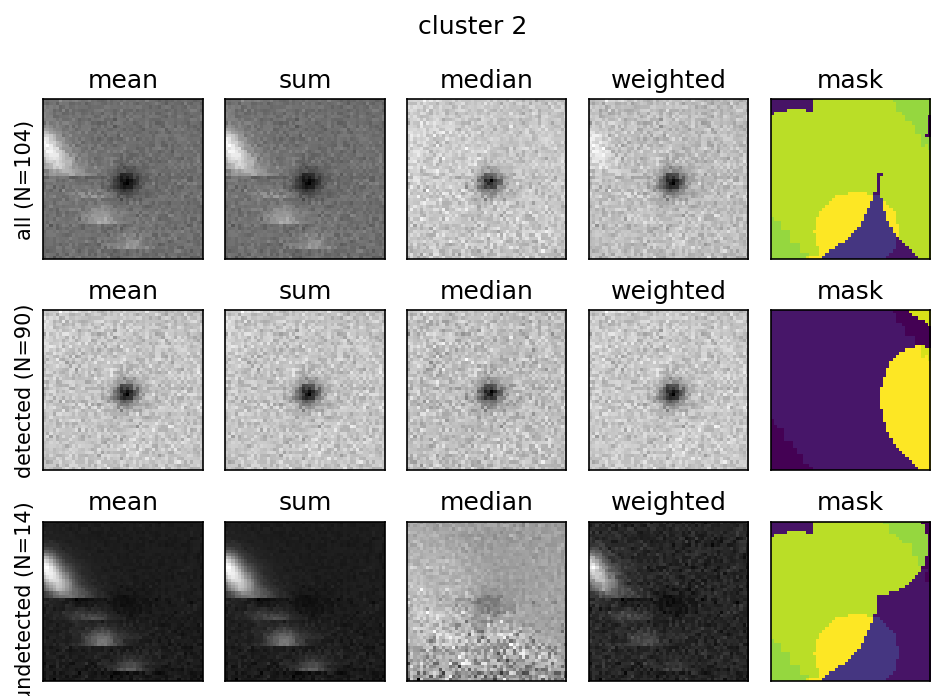

In [313]:
fig = coadds_plot(clusters[2])
fig.suptitle("cluster 2")
fig.tight_layout()
plt.show()

In [ ]:
c = load_summary("new", 22, 3.0, "regular", "asteroid")


In [136]:
# how do I clear a bit? just subtract the value, no?
np.bitwise_xor

8192

In [135]:
np.bitwise_or.reduce(clusters[220].summary['mask'])

array([[289792, 289792, 289792, ..., 262144, 262144, 262144],
       [289792, 289792, 289792, ..., 262144, 262144, 262144],
       [289792, 289792, 289792, ..., 262144, 262144, 262144],
       ...,
       [ 27029,  27029,  27029, ...,    405,    405,    405],
       [ 27029,  27029,  27029, ...,    405,    405,    405],
       [ 27029,  27029,  27029, ...,    405,    405,    405]], dtype=int32)

In [127]:
clusters[220].summary['mask_plane_dict'][0]['INJECTED']

13

In [145]:
import os
os.makedirs("figures", exist_ok=True)

In [314]:
for snr in [3.0]:
    for detector in range(1, 63):
        if detector in [2, 61]:
            continue
        try:
            clusters = load_summary("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
            continue

        for k in clusters:
            cp = f"figures/snr_{snr}_detector_{detector}_cluster_{k}_coadds.png"
            if not os.path.exists(cp):
                fig = coadds_plot(clusters[k])
                fig.suptitle(f"cluster {k} / detector {detector} / snr {snr}")
                fig.tight_layout()
                fig.savefig(cp)
                plt.close()
            
            lp = f"figures/snr_{snr}_detector_{detector}_cluster_{k}_light_curve.png"
            if not os.path.exists(lp):
                fig = lightcurve_plot(clusters[k])
                fig.suptitle("cluster 2")
                fig.suptitle(f"cluster {k} / detector {detector} / snr {snr}")
                fig.tight_layout()
                fig.savefig(lp)
                plt.close()

3.0 22
3.0 31
3.0 42



KeyboardInterrupt



Error in callback <function flush_figures at 0x7fee5fbe3e20> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
from PIL import Image


def combine_images(columns, space, images):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    return background

combined = combine_images(
    1, 
    0, 
    [Image("figures/snr_3.0_detector_1_cluster_0_coadds.png"), Image("figures/snr_3.0_detector_1_cluster_0_light_curve.png")]
)

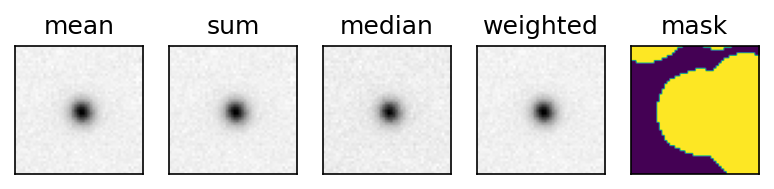

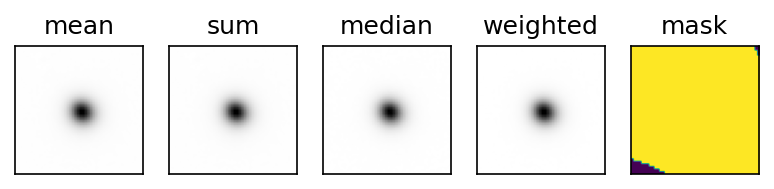

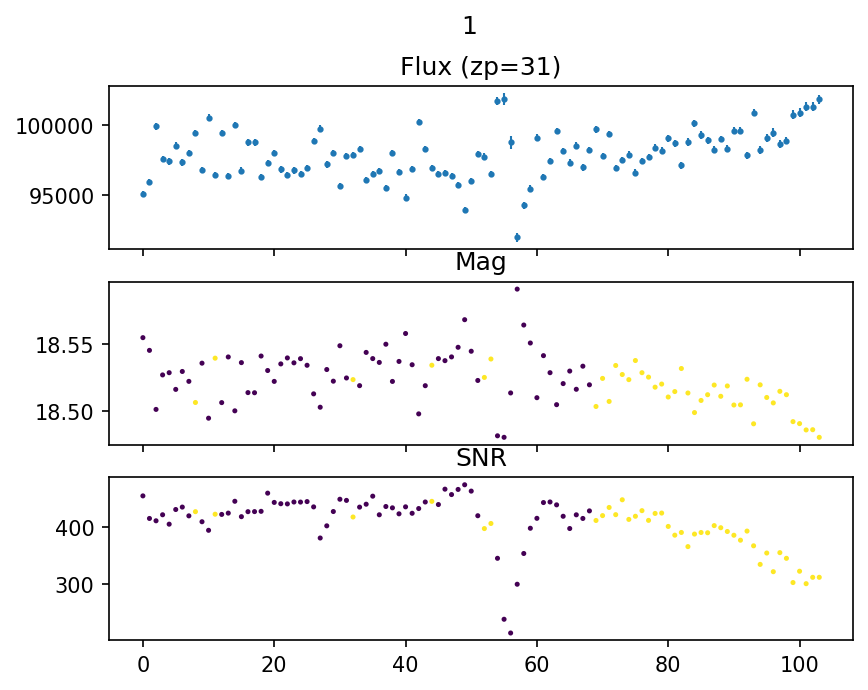

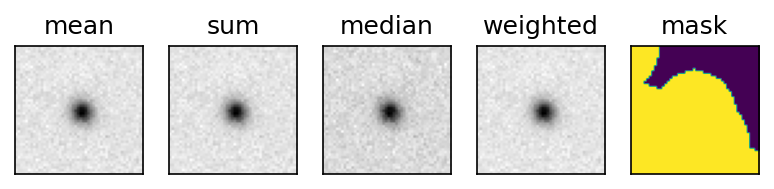

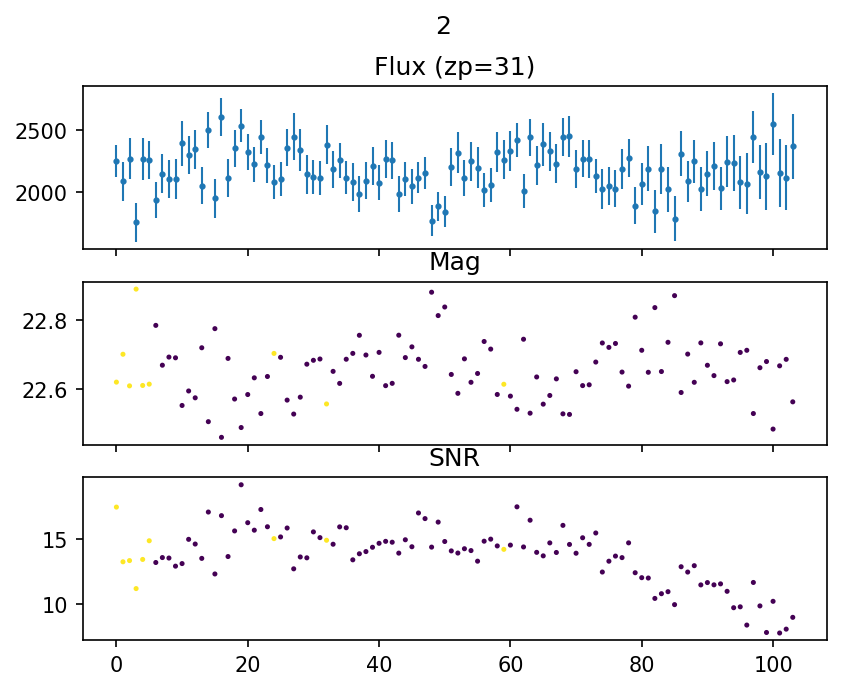

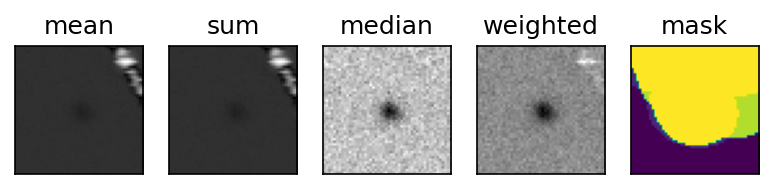

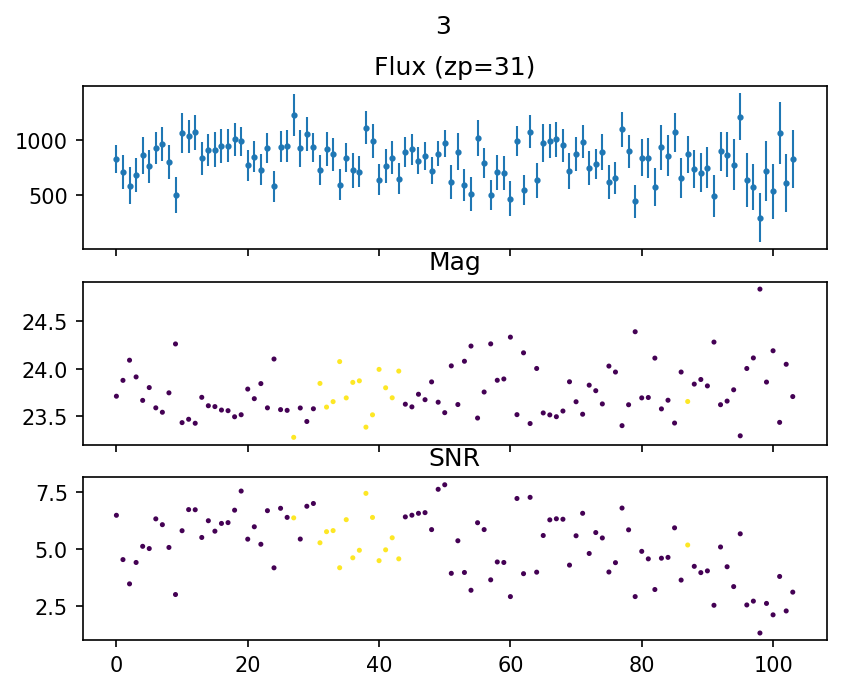

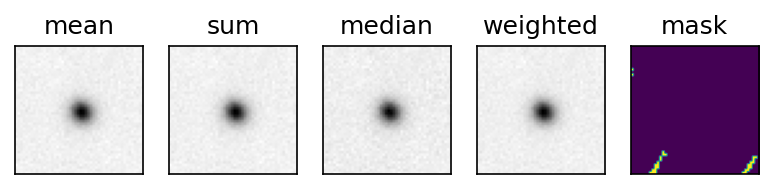

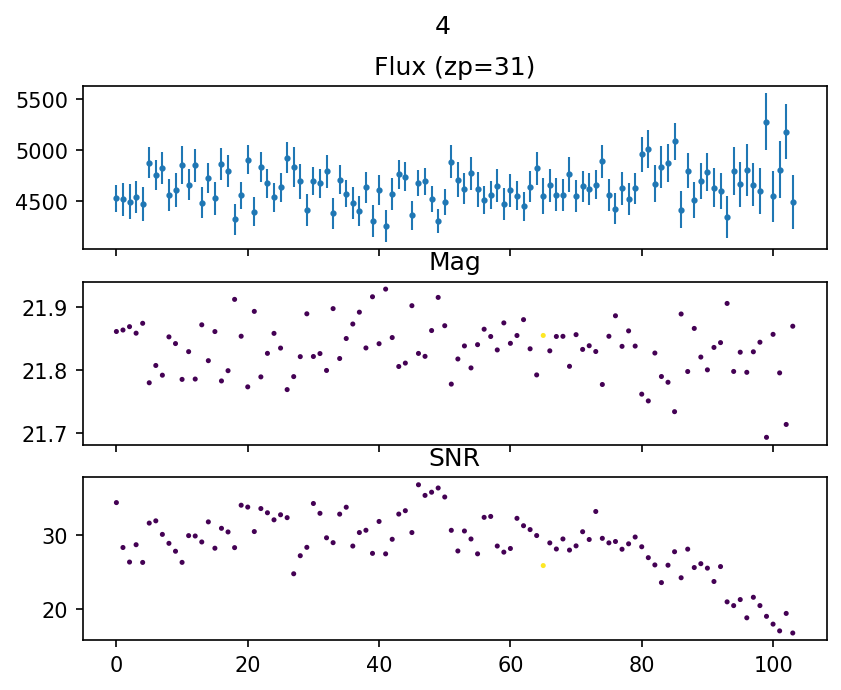

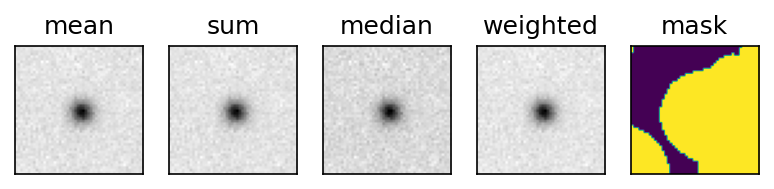

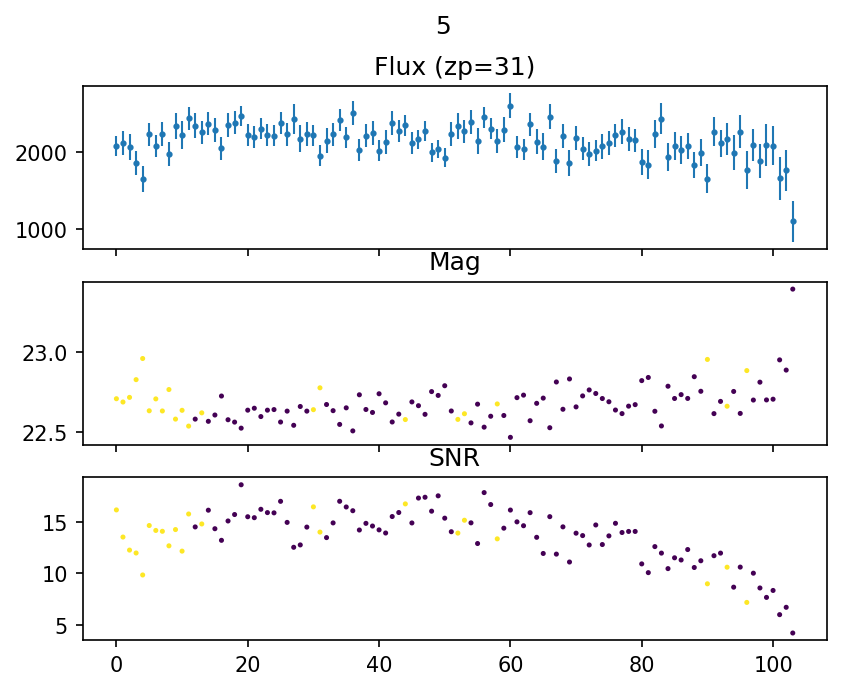

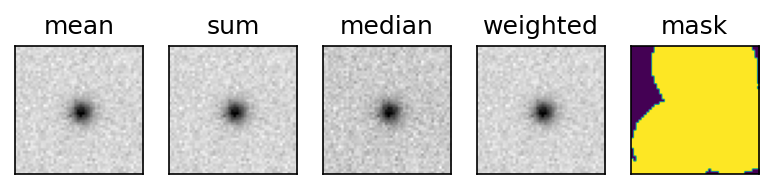

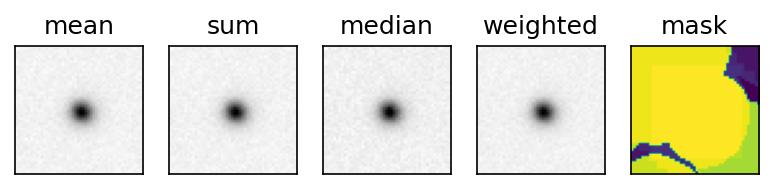

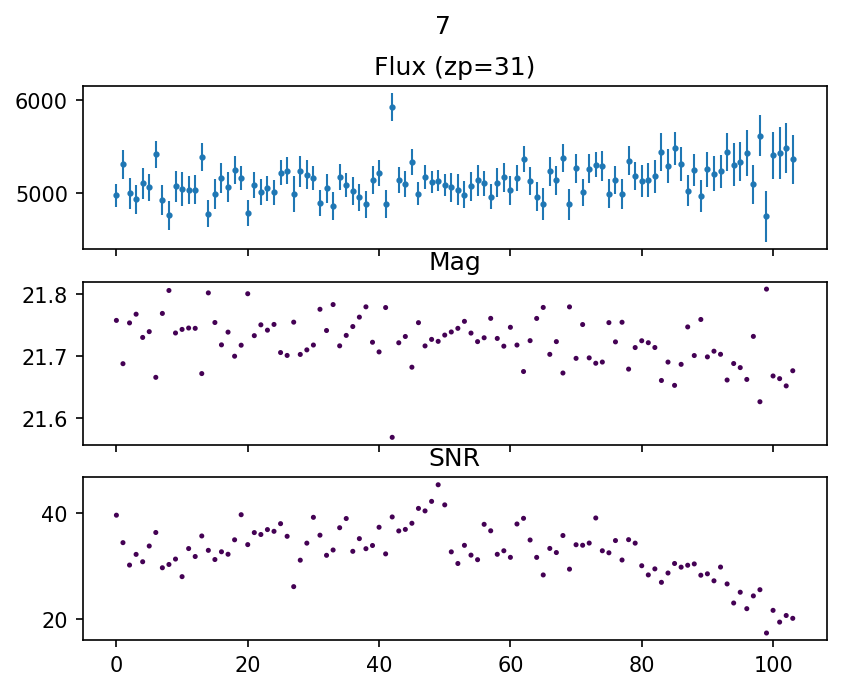

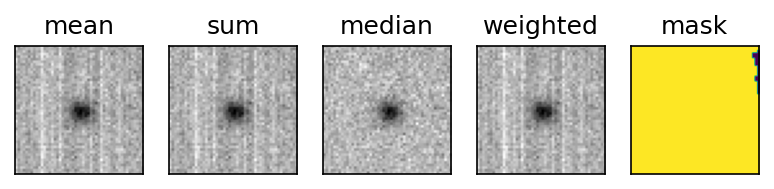

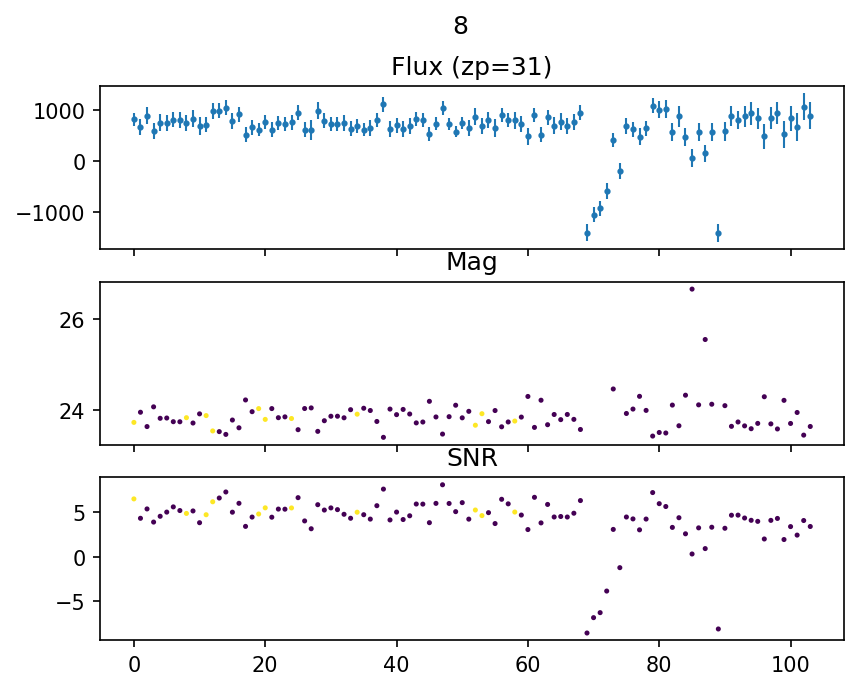

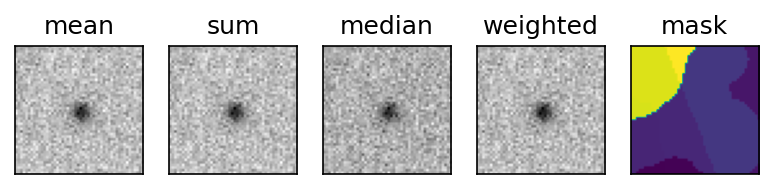

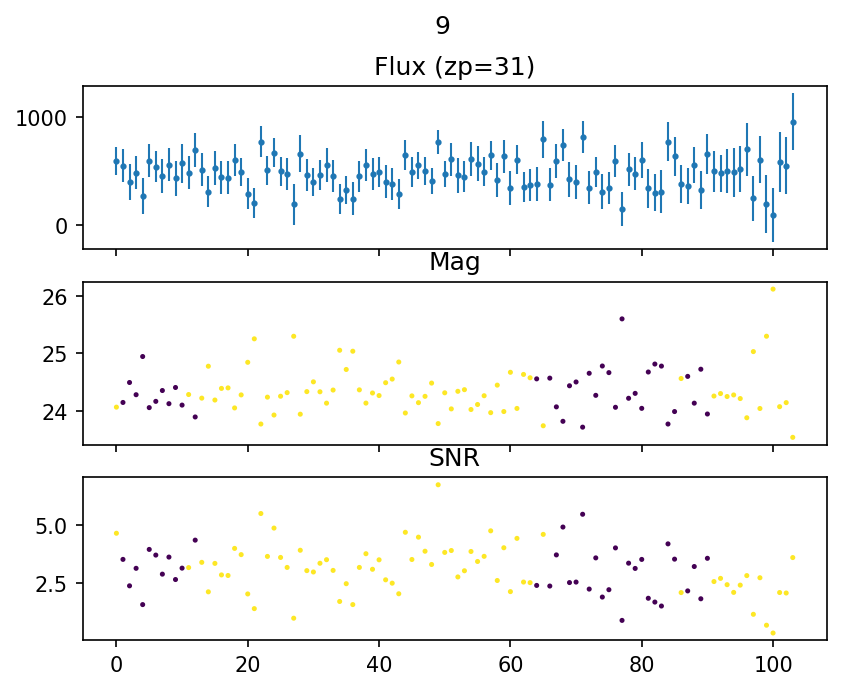

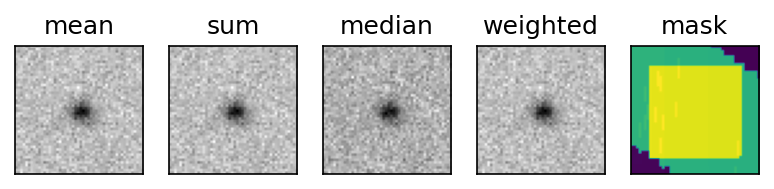

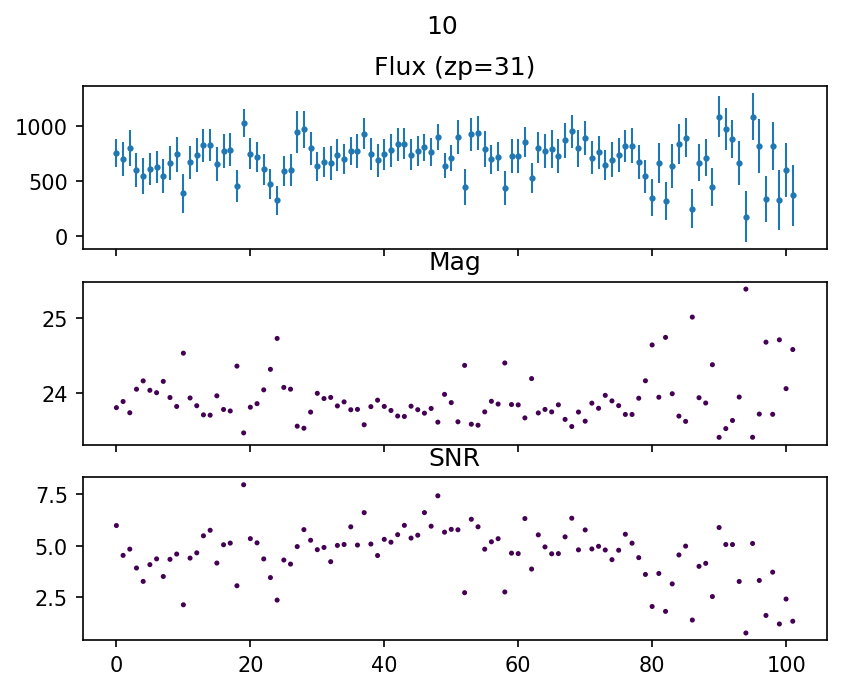

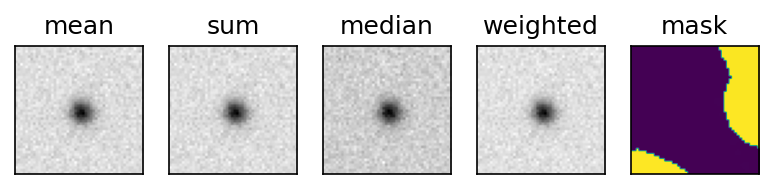

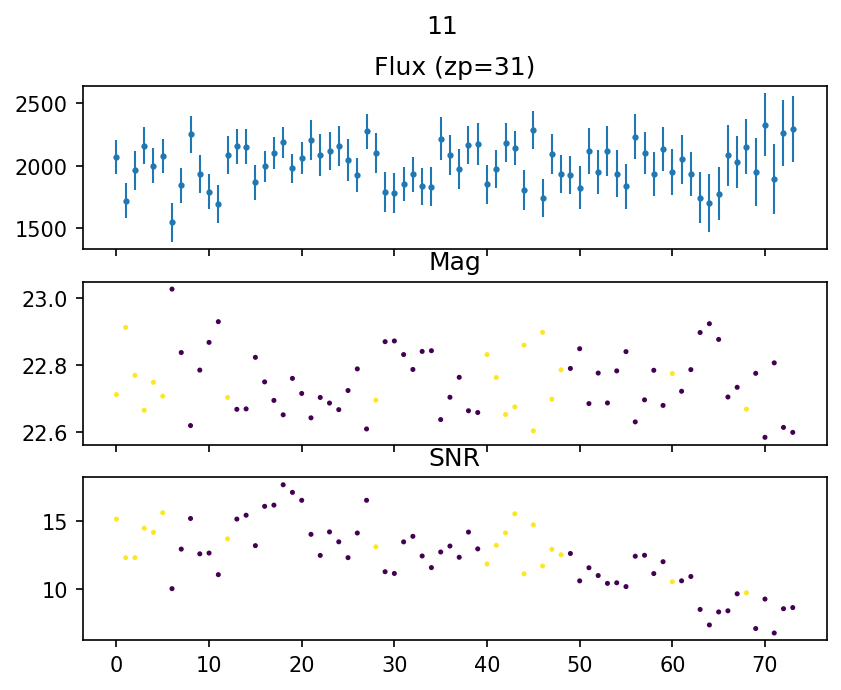

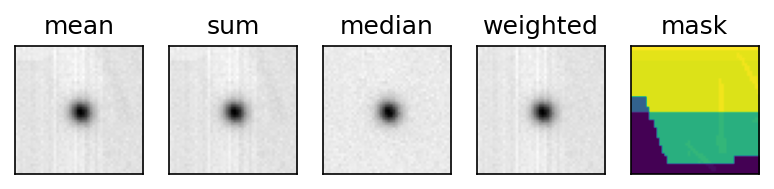

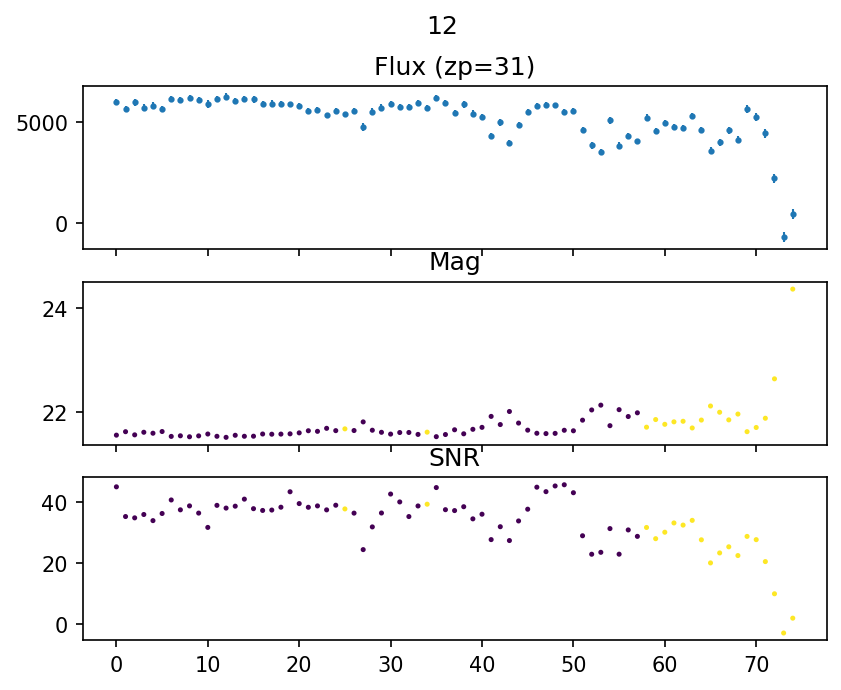

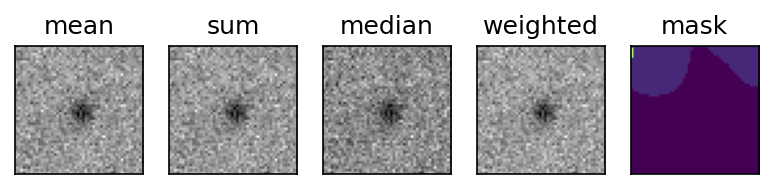

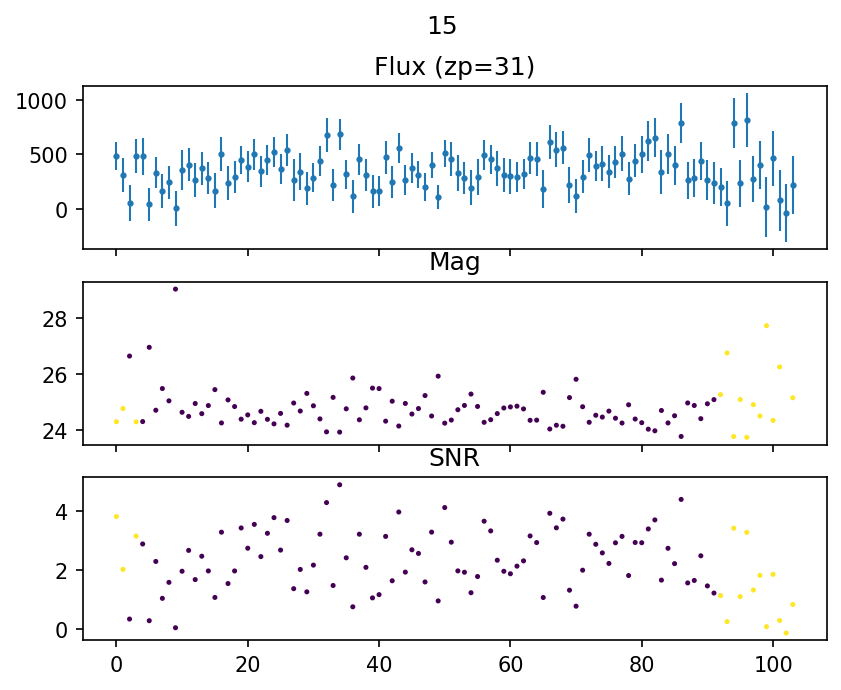

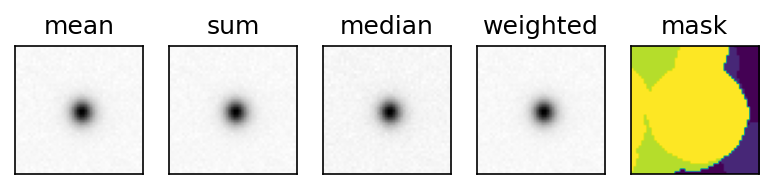

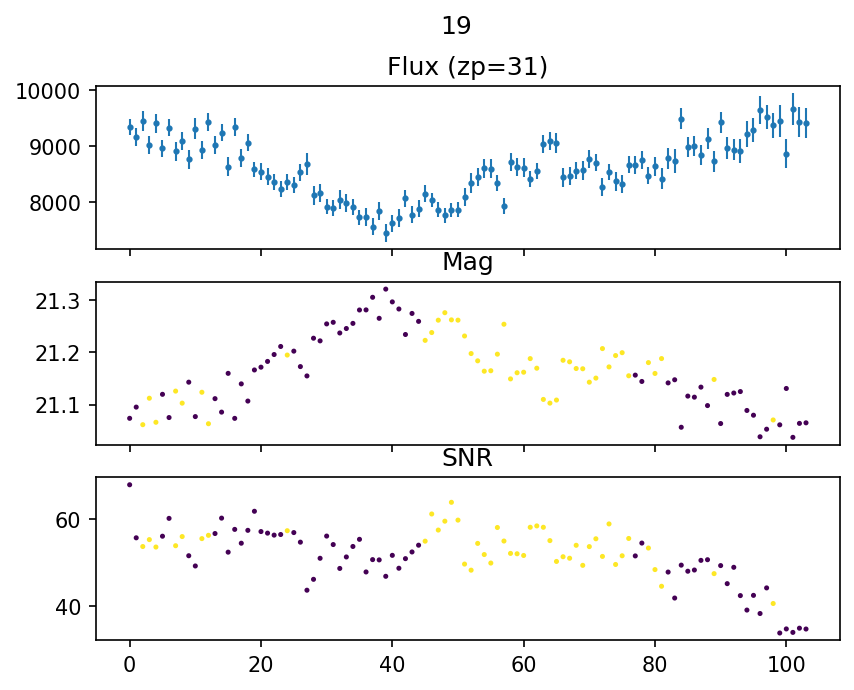

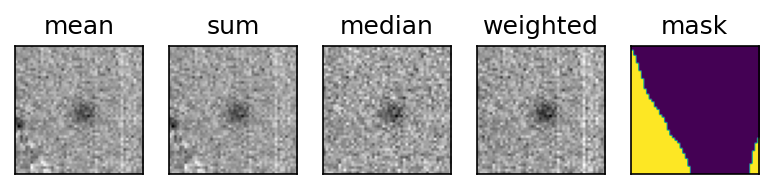

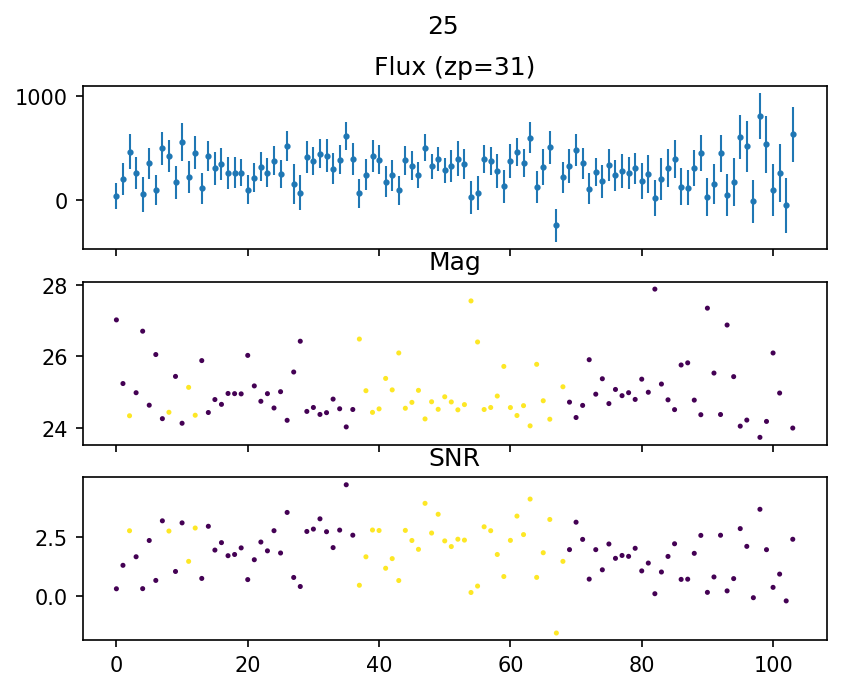

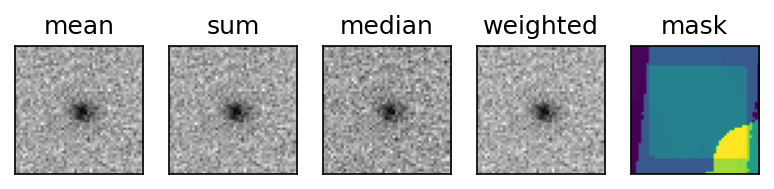

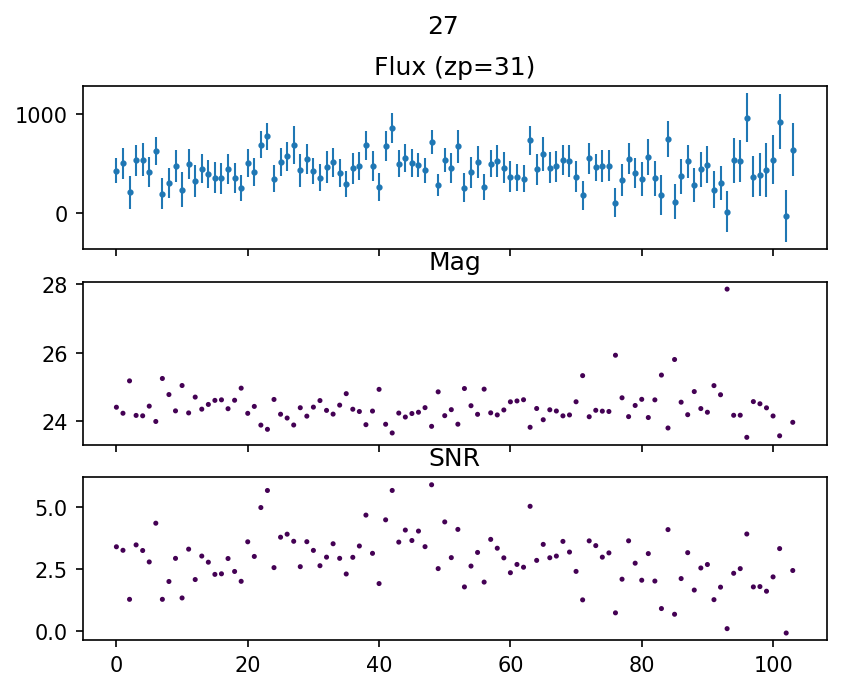

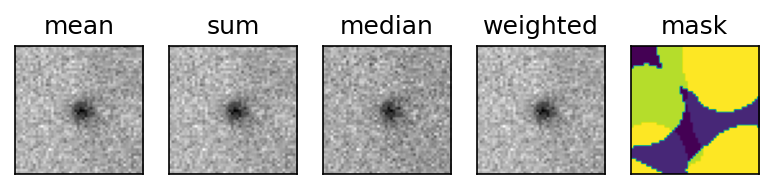

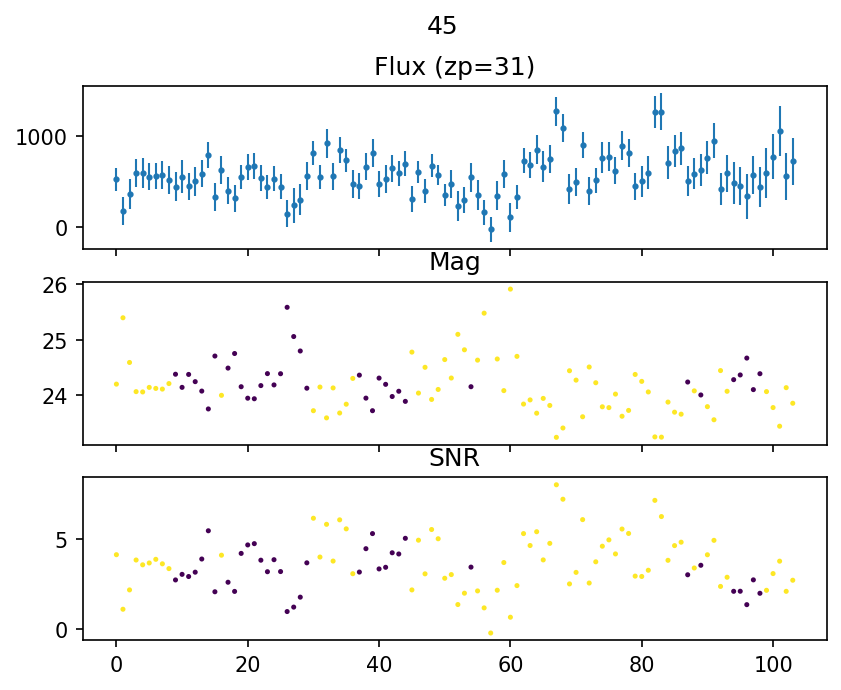

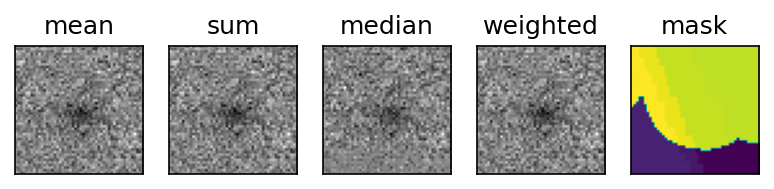

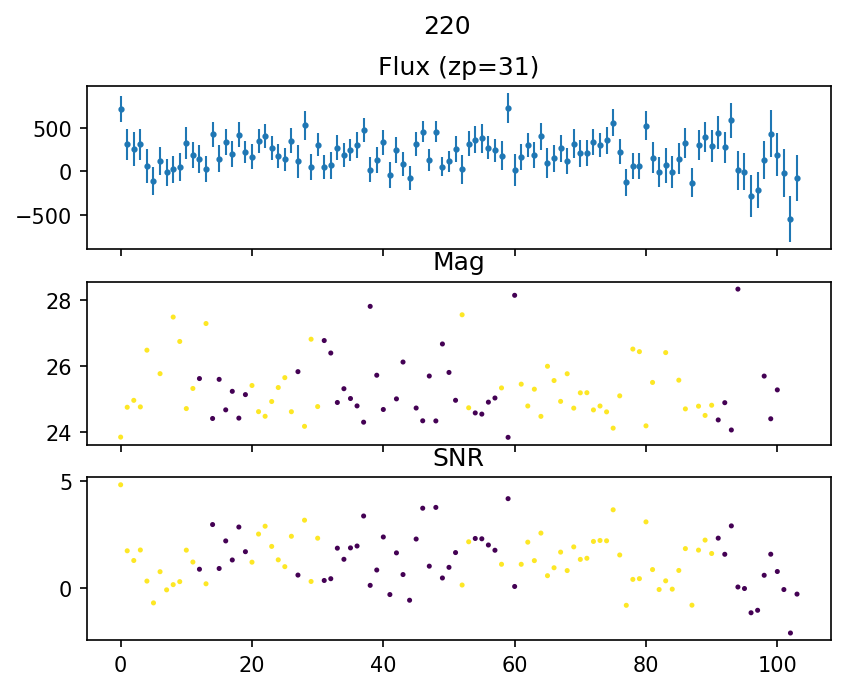

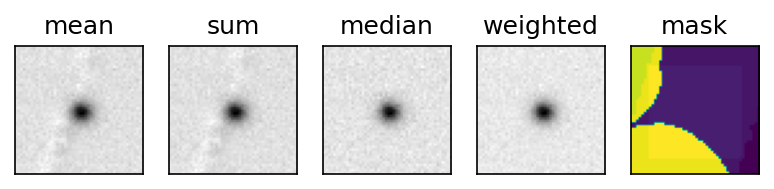

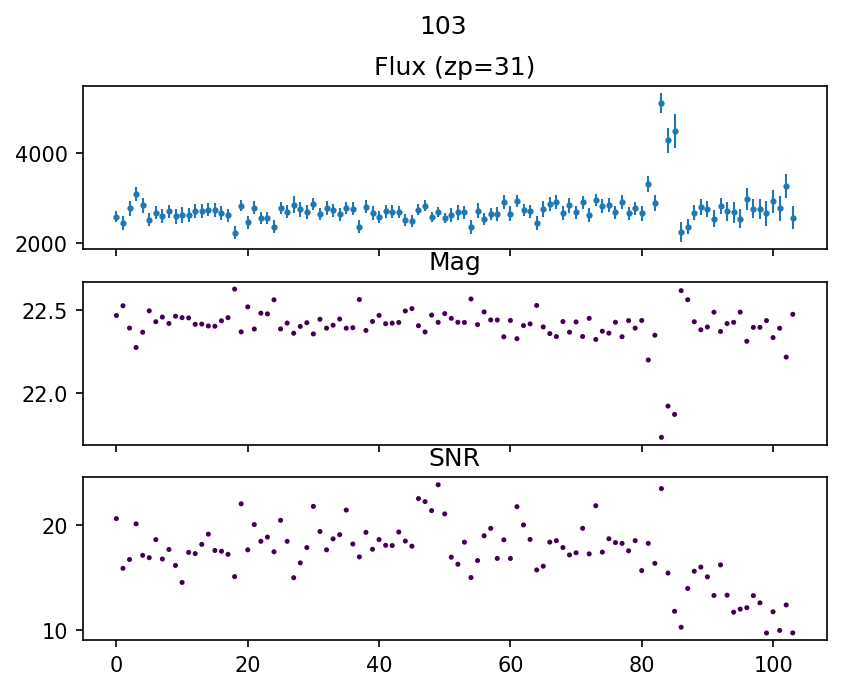

In [11]:
for k in clusters:
    fig = plot_summary_coadds(clusters[k].summary)
    plt.show()
    fig = plot_summary_light_curve(clusters[k].summary)
    fig.suptitle(k)
    plt.show()

In [16]:
clusters[220].summary['image'].shape

(104, 50, 50)

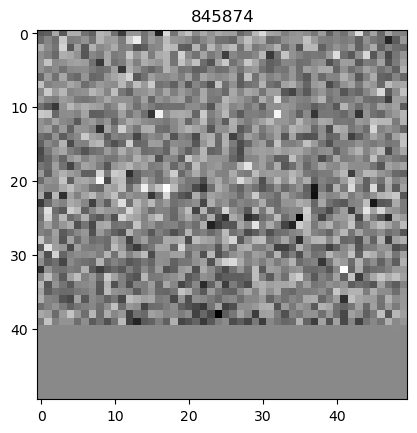

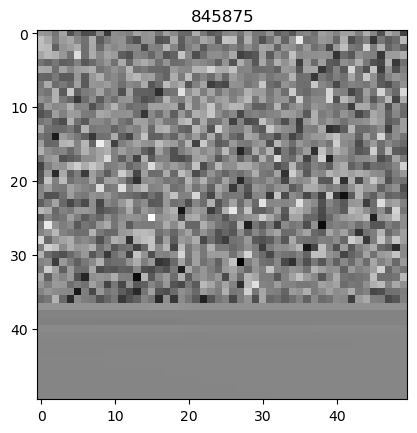

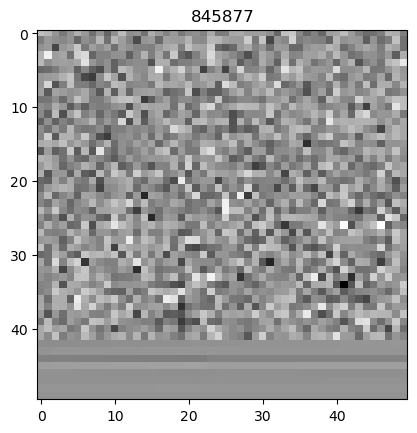

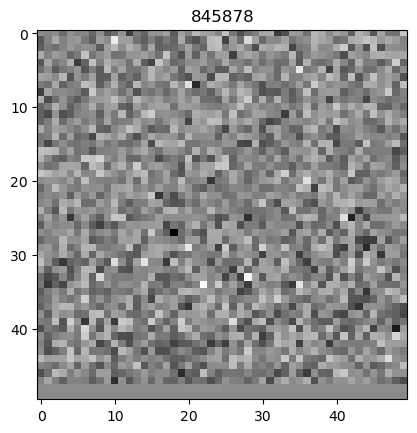

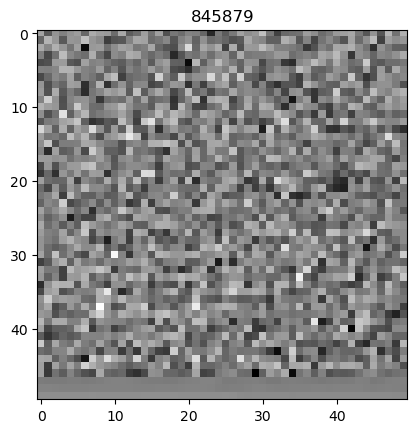

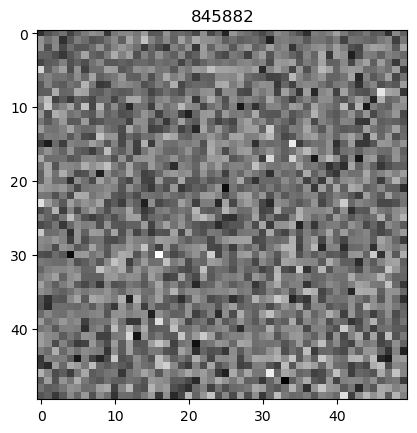

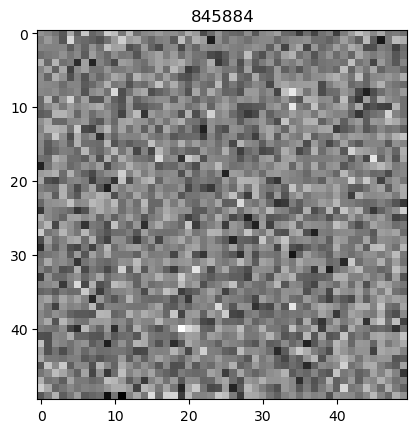

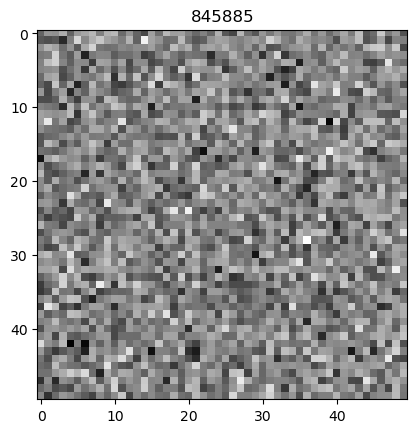

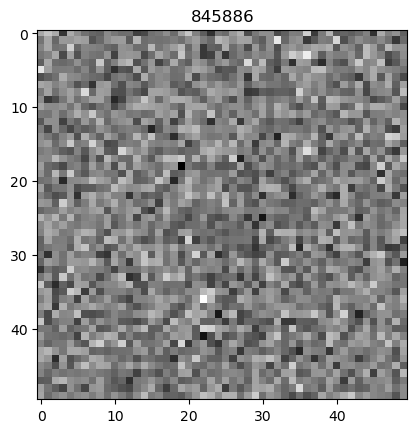

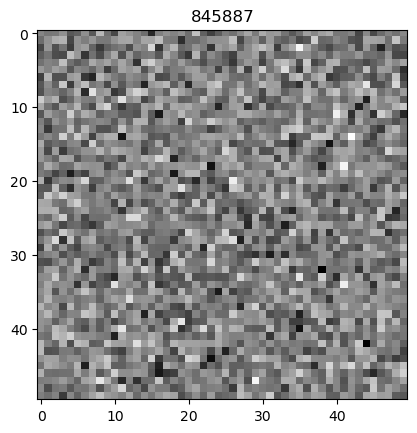

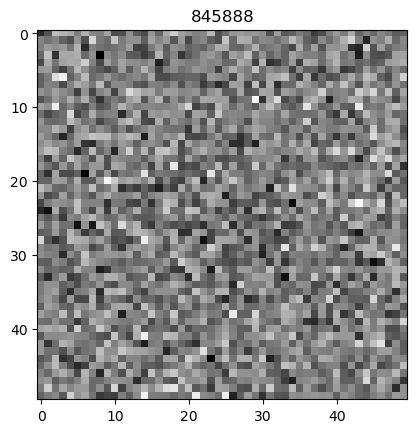

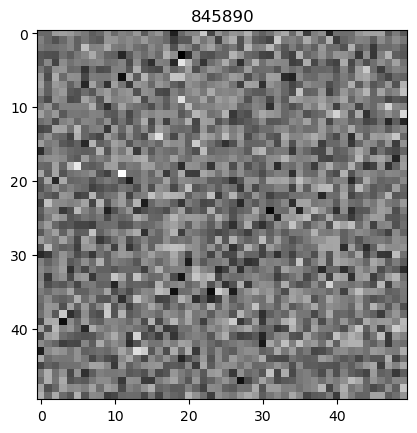

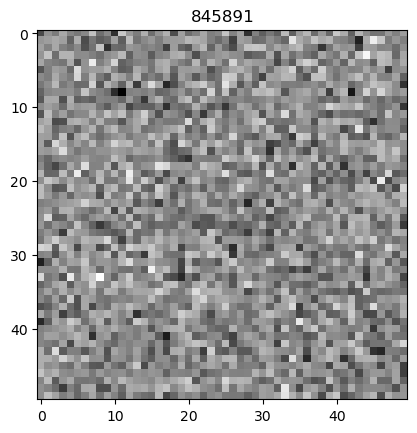

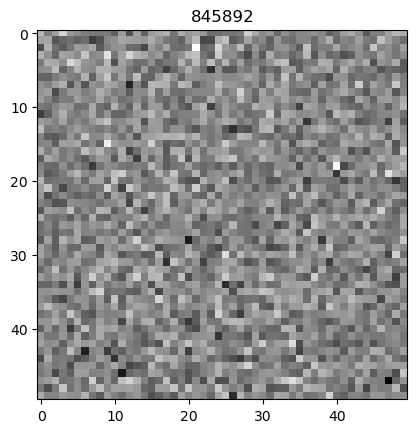

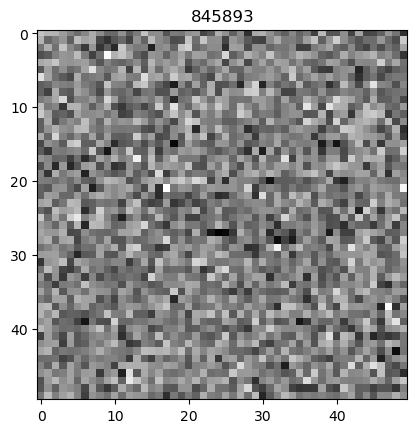

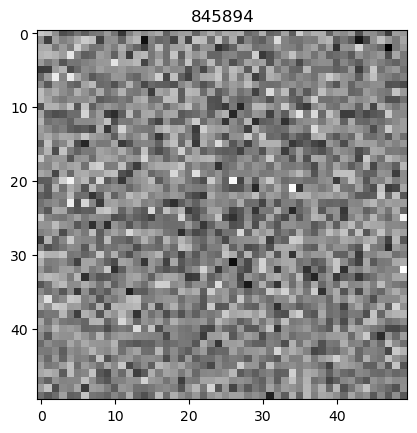

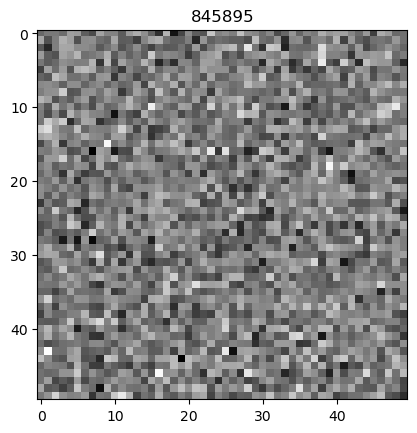

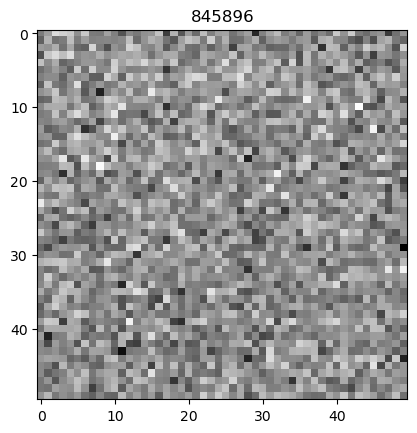

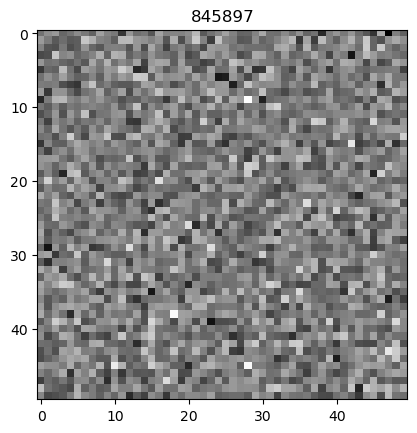

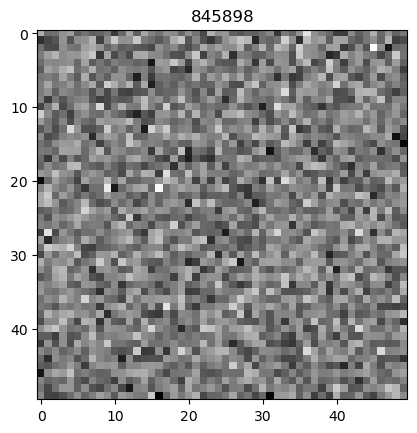

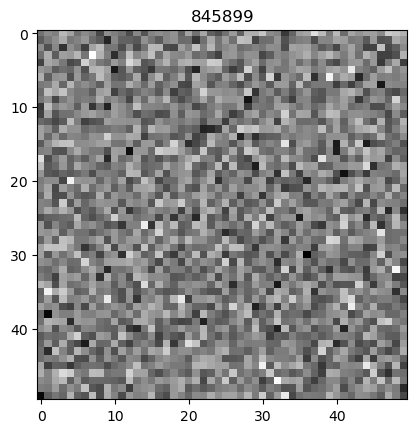

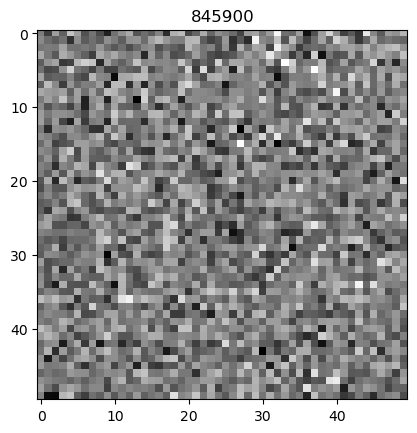

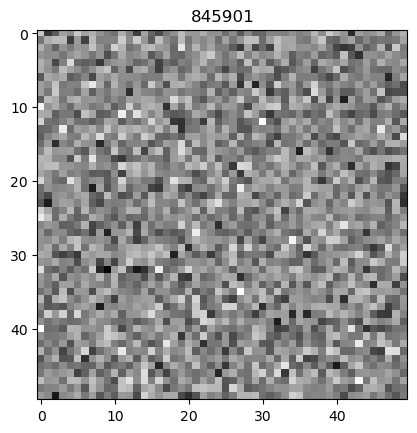

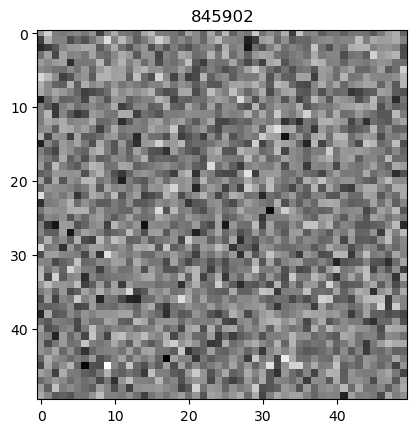

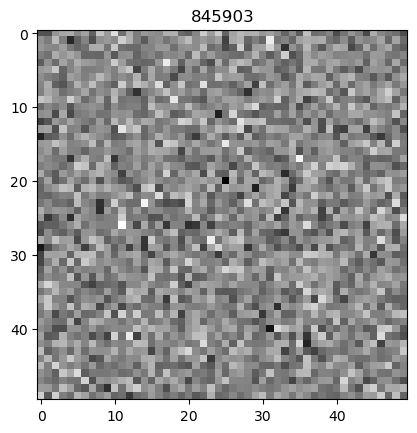

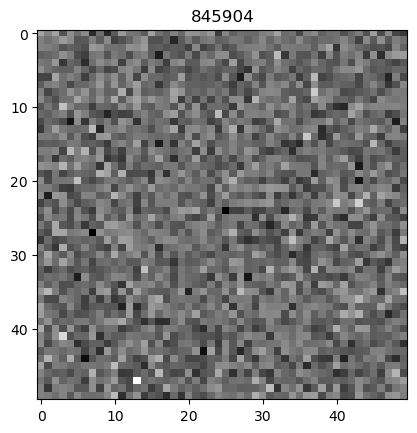

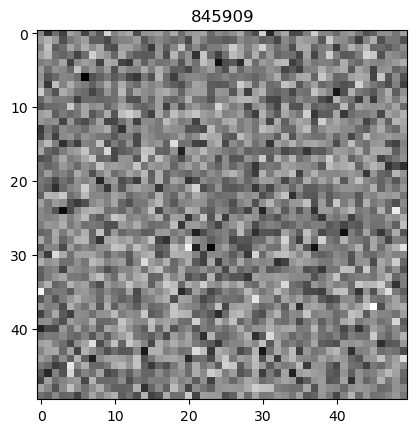

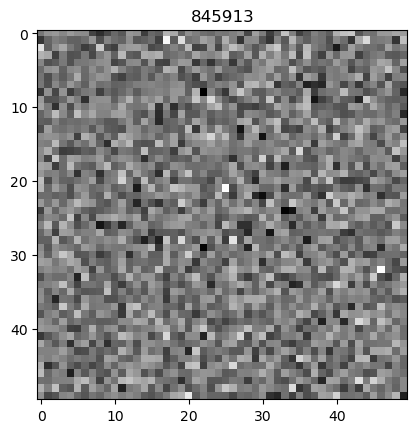

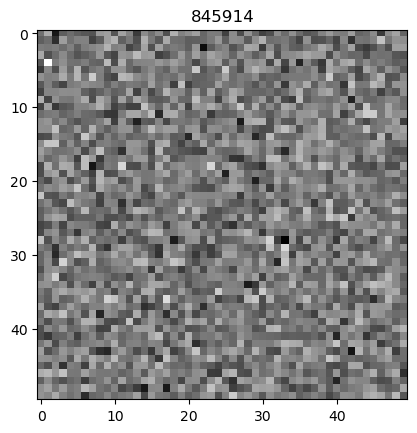

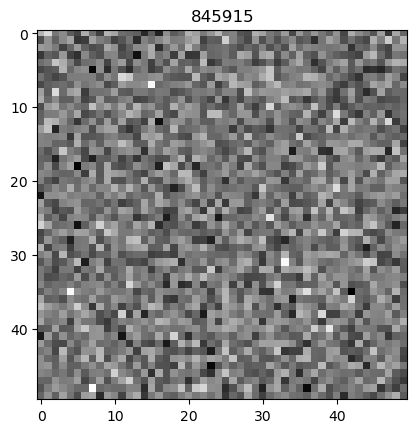

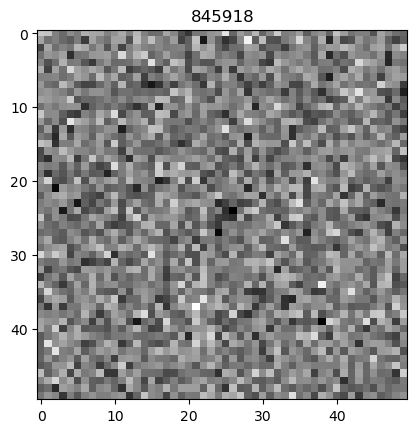

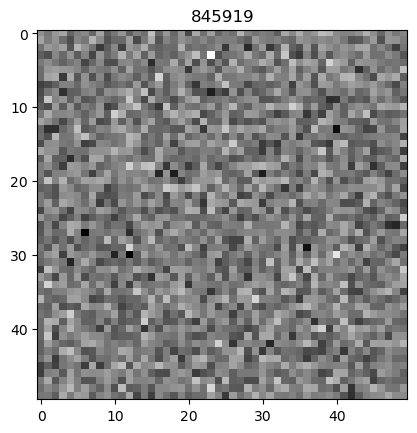

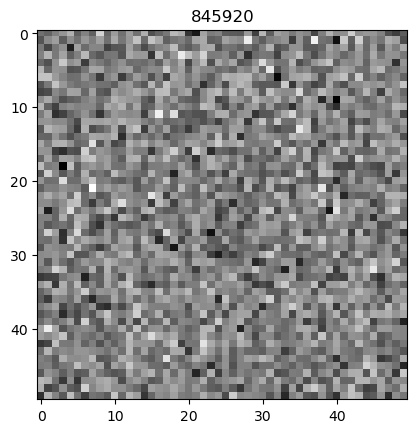

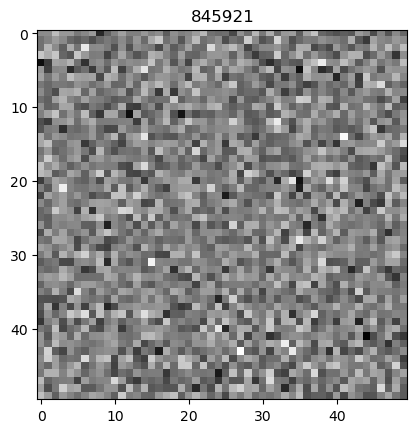

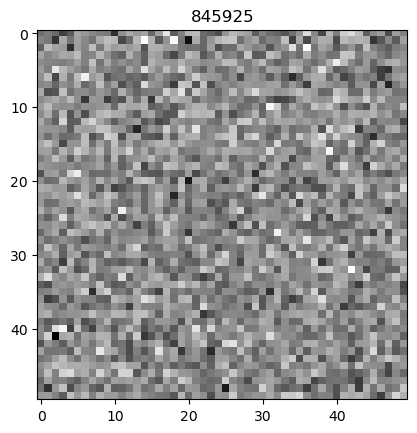

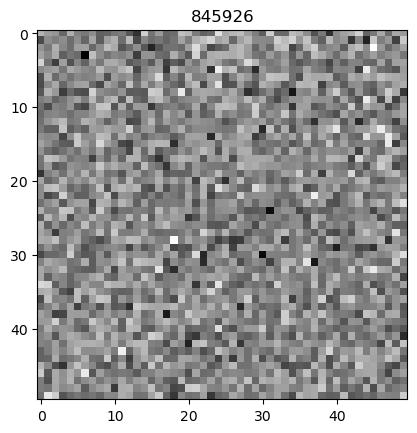

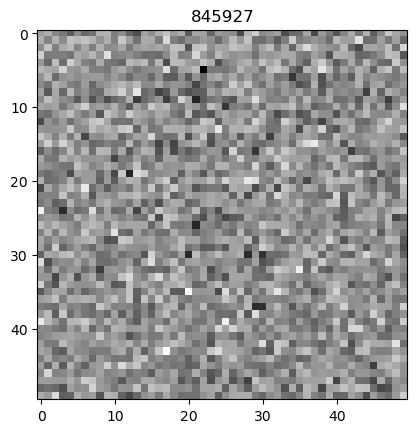

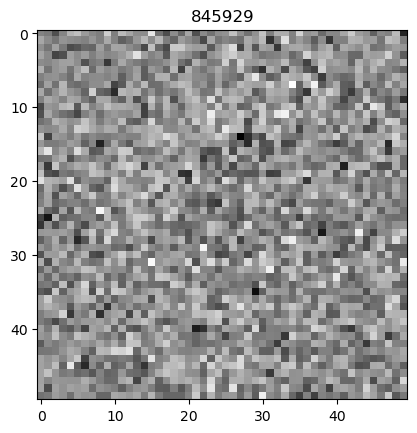

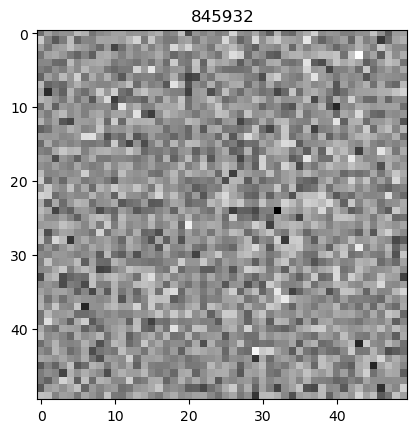

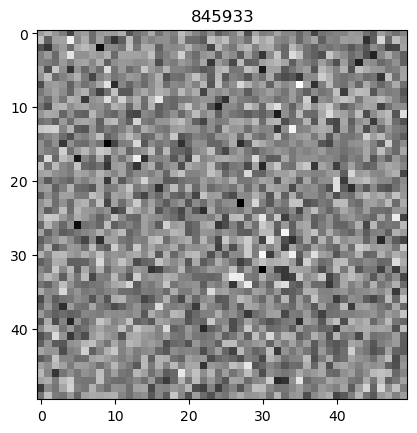

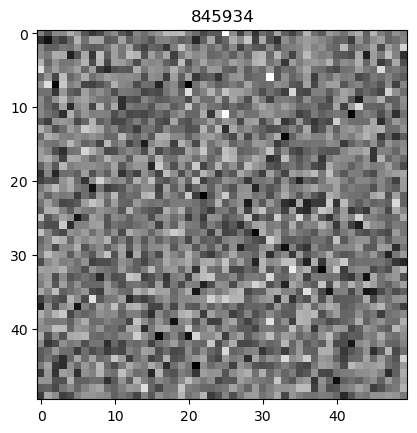

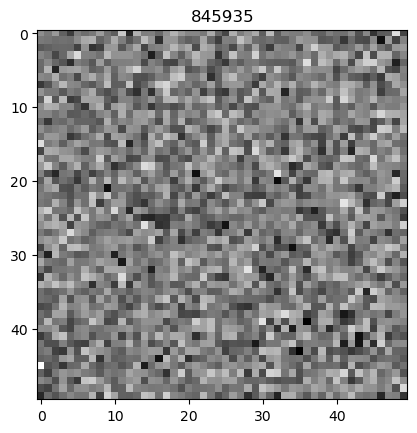

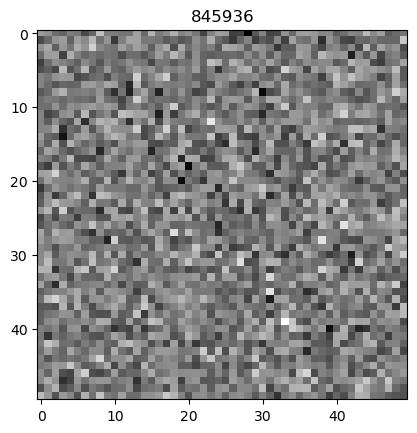

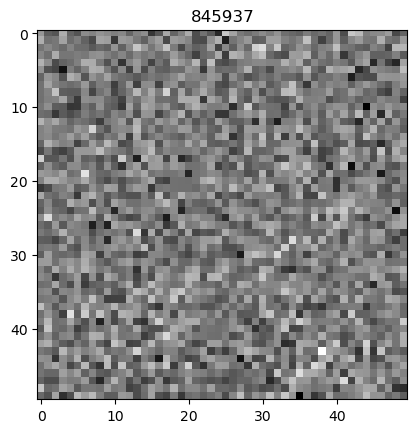

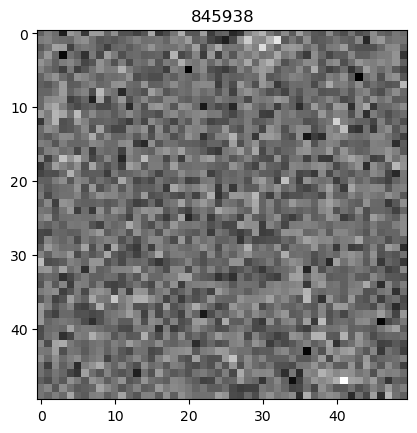

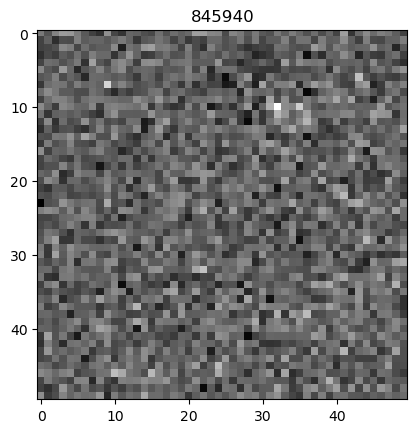

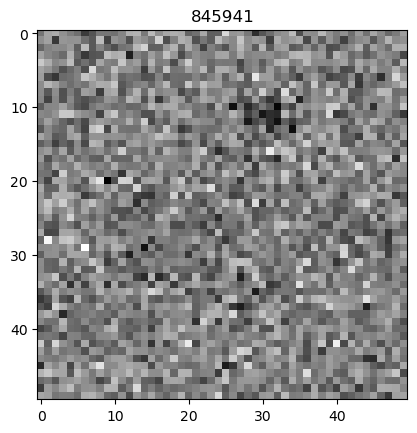

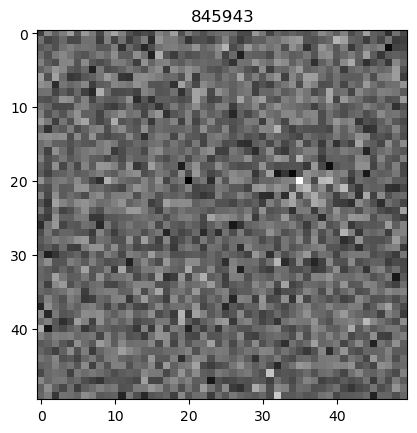

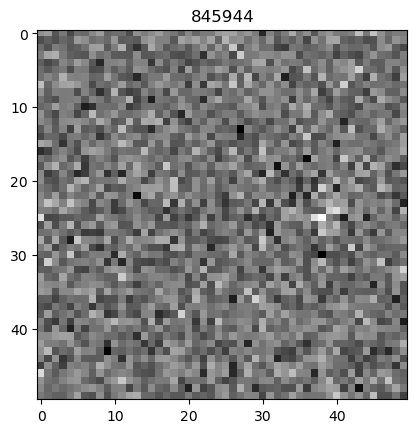

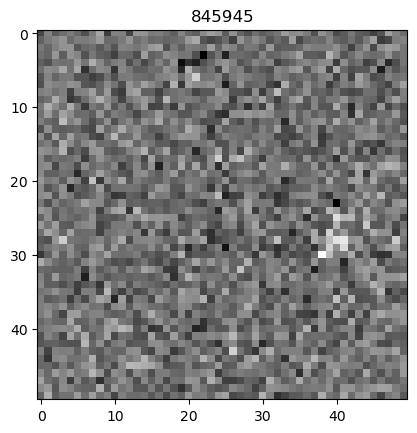

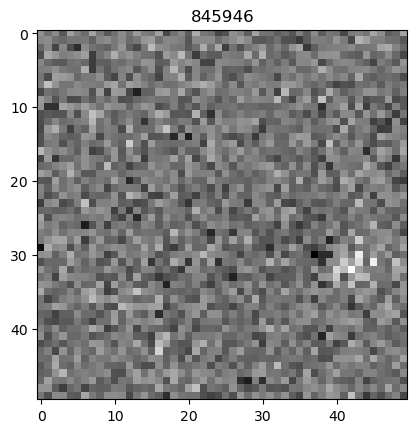

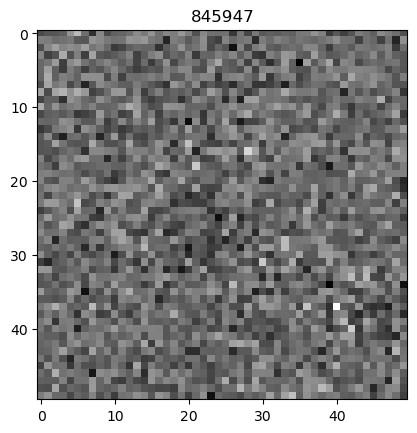

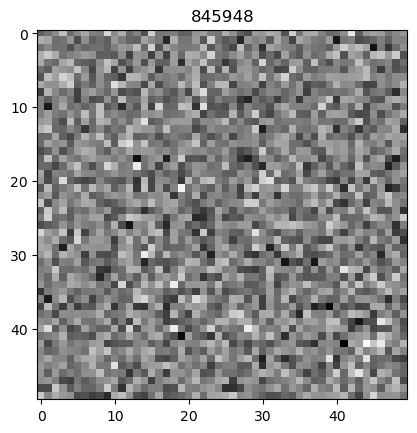

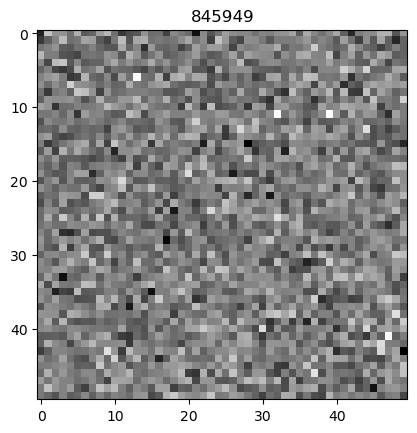

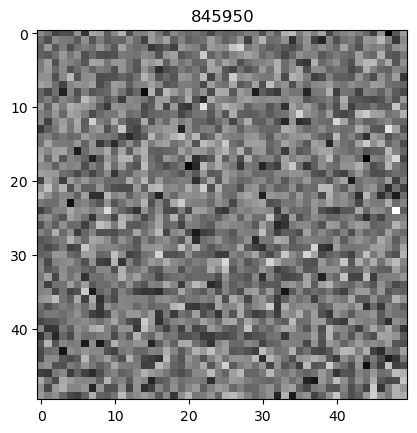

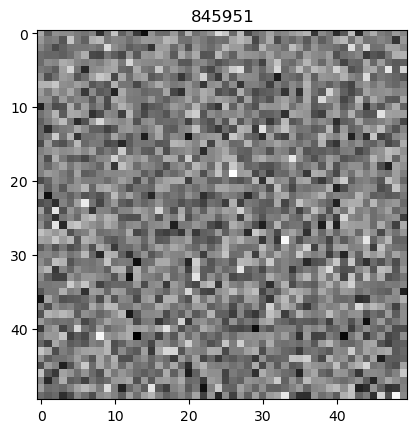

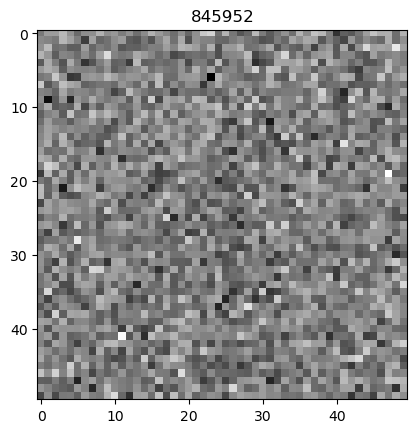

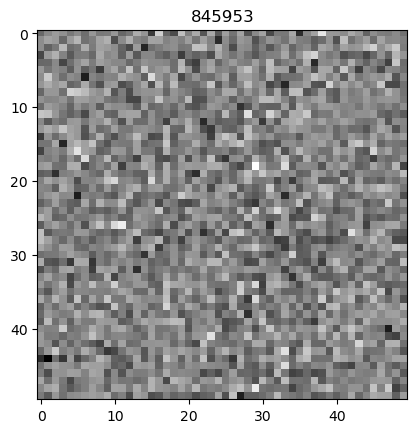

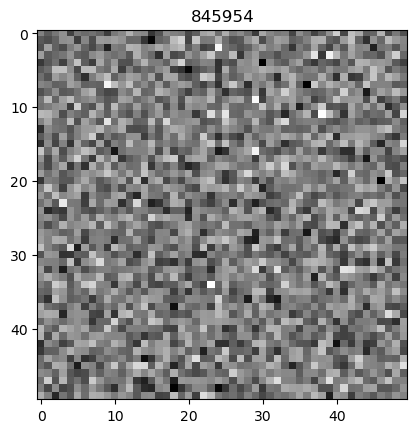

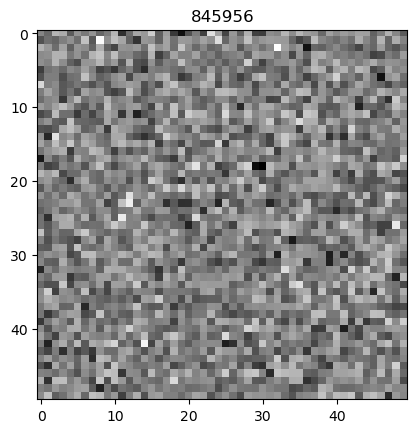

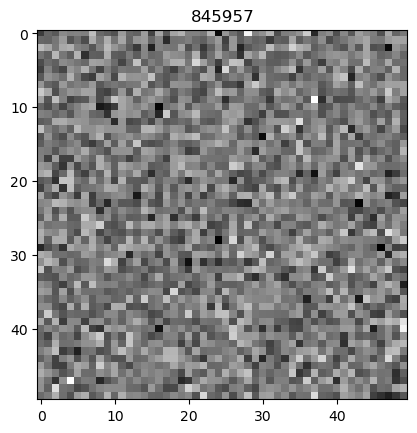

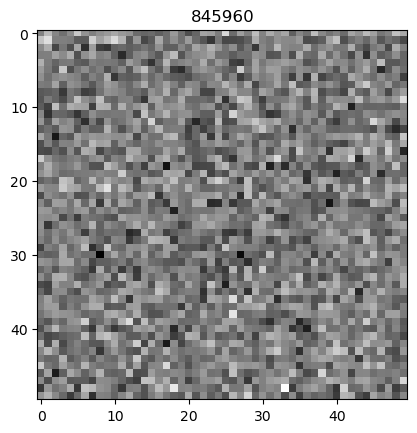

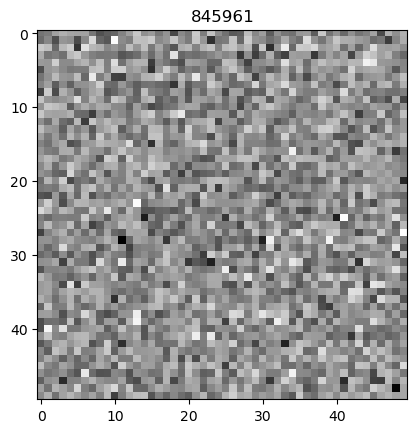

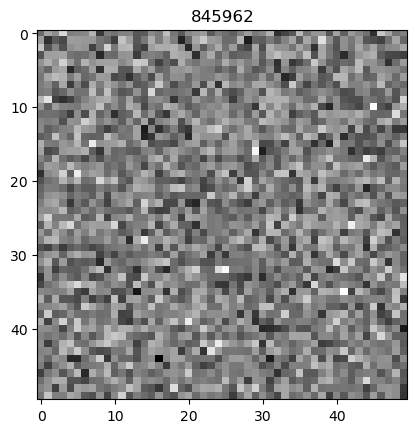

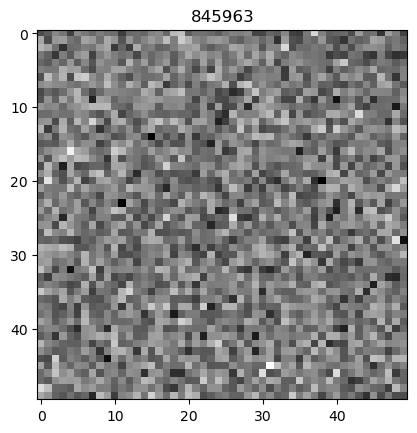

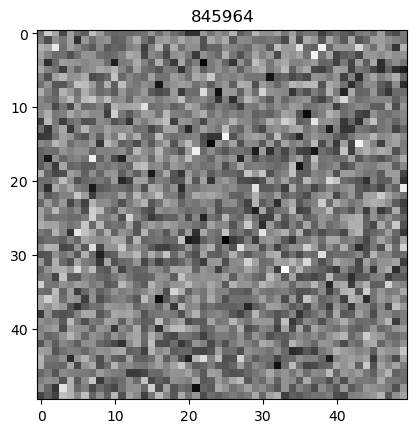

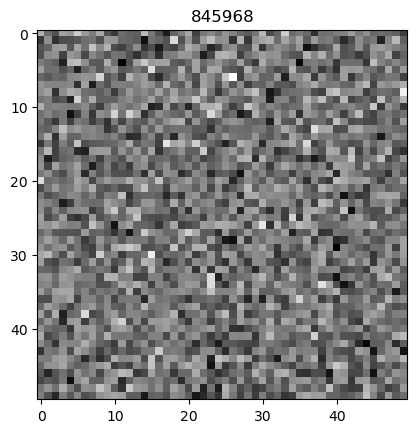

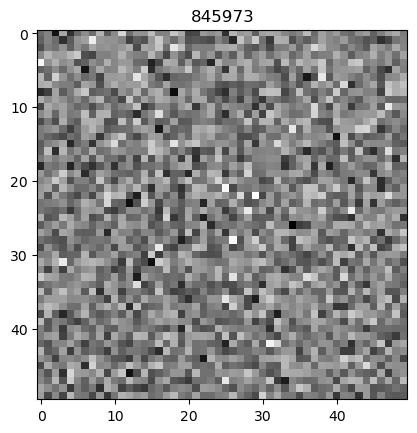

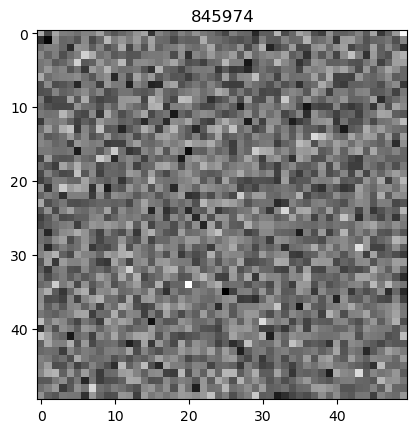

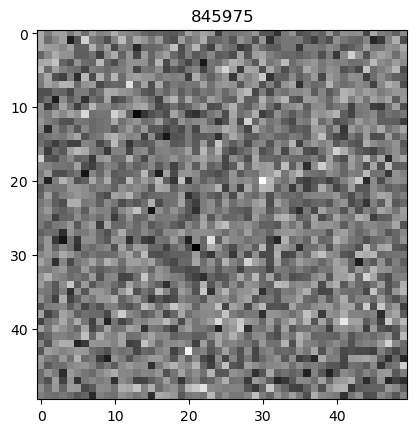

In [59]:
for i in range(len(clusters[220].summary['image'])):
    plt.imshow(clusters[220].summary['image'][i], cmap='gray_r')
    plt.title(clusters[220].summary['expnum'][i])
    plt.show()

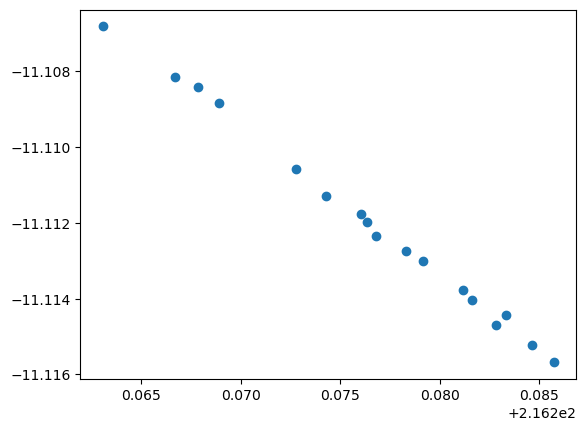

In [64]:
plt.scatter(clusters[220].points[:, 0], clusters[220].points[:, 1])
plt.show()

In [77]:
clusters[220].points[:, -1].astype(int)

array([845900, 845909, 845917, 845896, 845894, 845952, 845912, 845886,
       845918, 845926, 845931, 845945, 845948, 845890, 845920, 845965,
       845902])

In [85]:
e = np.equal.outer(clusters[220].points[:, -1].astype(int), clusters[220].summary['expnum'])

In [109]:
included = []
excluded = []
e2 = clusters[220].points[:, -1].astype(int)
for i, e in enumerate(clusters[220].summary['expnum']):
    if e in e2:
        included.append(i)
    else:
        excluded.append(i)


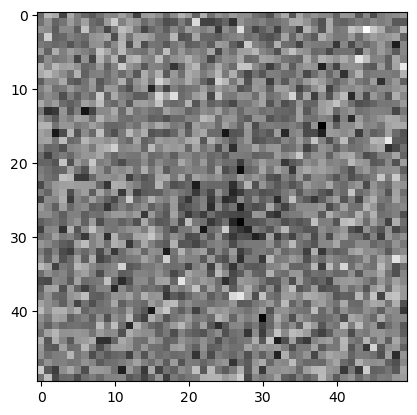

In [111]:
plt.imshow(np.median(clusters[220].summary['image'][included], axis=0), cmap='gray_r')
plt.show()
plt.imshow(np.median(clusters[220].summary['image'][excluded], axis=0), cmap='gray_r')
plt.show()

In [67]:
clusters[220].summary

{'expnum': array([845872, 845873, 845874, 845875, 845876, 845877, 845878, 845879,
        845880, 845881, 845882, 845883, 845884, 845885, 845886, 845887,
        845888, 845889, 845890, 845891, 845892, 845893, 845894, 845895,
        845896, 845897, 845898, 845899, 845900, 845901, 845902, 845903,
        845904, 845905, 845906, 845907, 845908, 845909, 845910, 845911,
        845912, 845913, 845914, 845915, 845916, 845917, 845918, 845919,
        845920, 845921, 845922, 845923, 845924, 845925, 845926, 845927,
        845928, 845929, 845930, 845931, 845932, 845933, 845934, 845935,
        845936, 845937, 845938, 845939, 845940, 845941, 845942, 845943,
        845944, 845945, 845946, 845947, 845948, 845949, 845950, 845951,
        845952, 845953, 845954, 845955, 845956, 845957, 845958, 845959,
        845960, 845961, 845962, 845963, 845964, 845965, 845966, 845967,
        845968, 845969, 845970, 845971, 845972, 845973, 845974, 845975]),
 'image': array([[[-2.33552151e+01,  1.12860413e+01,

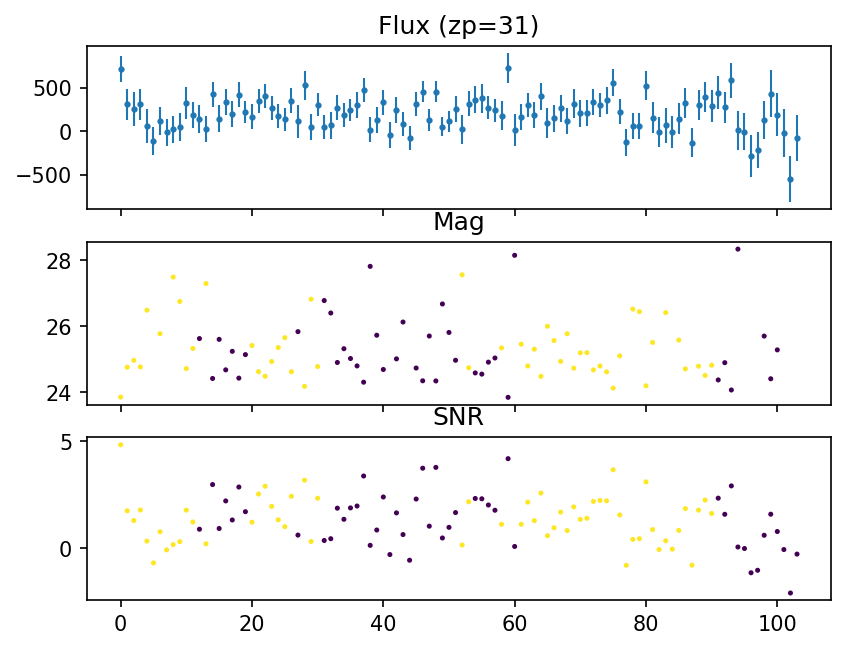

In [66]:
fig = plot_summary_light_curve(clusters[220].summary)
plt.show()

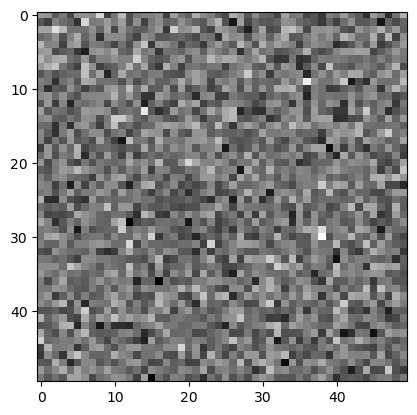

In [63]:
plt.imshow(np.mean(clusters[220].summary['image'][92:], axis=0), cmap='gray_r')
plt.show()

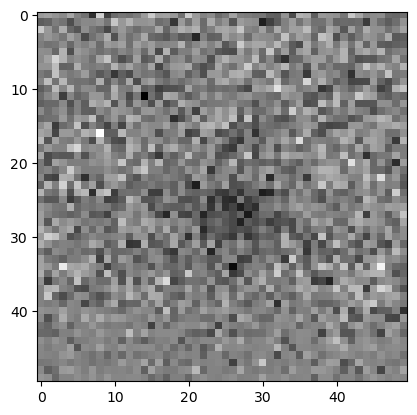

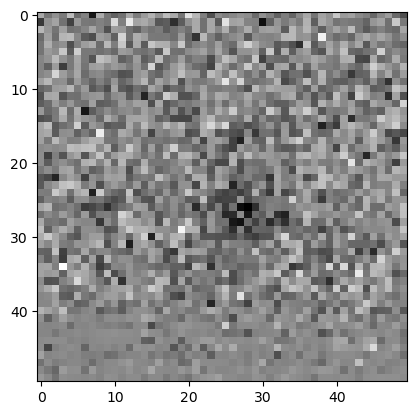

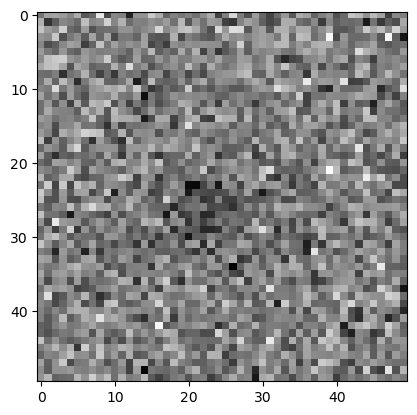

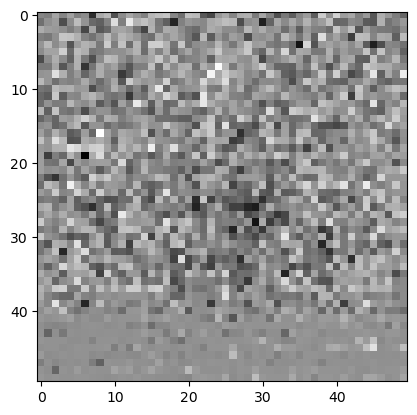

In [22]:
plt.imshow(np.median(clusters[220].summary['image'], axis=0), cmap='gray_r')
plt.show()
plt.imshow(np.median(clusters[220].summary['image'][:52], axis=0), cmap='gray_r')
plt.show()
plt.imshow(np.median(clusters[220].summary['image'][52:], axis=0), cmap='gray_r')
plt.show()
plt.imshow(np.median(clusters[220].summary['image'][:26], axis=0), cmap='gray_r')
plt.show()